# Testing if I can make something better than GeoEnrich quickly

The goal is to make something that works the same way as `geoenrich` but in a much more modular and general-purpose way.

The constraints are:
- Must be able to get an area around a point (which we'll call a "seascape" from now on)
- Must be able to compute a summary of that seascape
- Must scale well to large amounts of points
- Shouldn't make multiple requests for the same "background". E.g.: if we want to get the bathymetry seascape, we should only request one map and then cut it up locally (to avoid DDoS-ing the data server)

## Get a GLORYS square near a series of points

In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import cartopy.crs as ccrs

import xarray as xr
import copernicusmarine as cmems

In [2]:
def generate_points(n_points, min_lon, max_lon, min_lat, max_lat):
    lats = np.random.uniform(min_lat, max_lat, size=(n_points, 1))
    lons = np.random.uniform(min_lon, max_lon, size=(n_points, 1))
    points = np.concatenate([lons, lats], axis=1)
    return points

def plot_points(points):
    ax = plt.gca() # Must be GeoAxes
    ax.scatter(points[:,0], points[:, 1], transform=ccrs.PlateCarree(), marker='x', c='black')

def get_request_extent(points, seascape_size):
    # Buffer should be in km but to start with I'll do it in degrees
    return {
    'maximum_latitude': points[:,1].max()+1/12+seascape_size/2,
    'minimum_latitude': points[:,1].min()-1/12-seascape_size/2,
    'maximum_longitude': points[:,0].max()+1/12+seascape_size/2,
    'minimum_longitude': points[:,0].min()-1/12-seascape_size/2,
    }

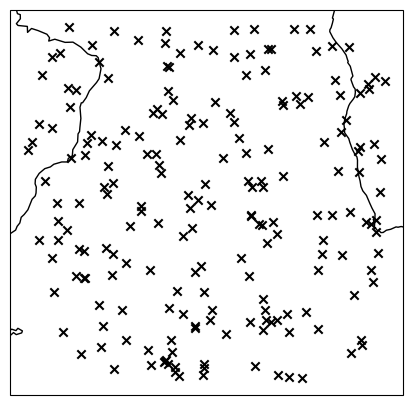

In [ ]:
# Generate random coordinates
n_points = 10
points = generate_points(200, -50, 20, -60, 0)

fig, ax = plt.subplots(1,1,figsize=(10,5), subplot_kw={'projection':ccrs.Robinson()})

ax.coastlines()
plot_points(points)


In [8]:
# Glorys data request
buffer = 1 # degrees
extent = get_request_extent(points, buffer)
data_request = {
    'dataset_id': 'cmems_mod_glo_phy_my_0.083deg_P1D-m',
    'variables': ['zos', 'thetao', 'so', 'mlotst'],
    'start_datetime': "2000-01-01",
    'end_datetime' : "2000-12-31",
    'maximum_latitude': extent['maximum_latitude'],
    'minimum_latitude': extent['minimum_latitude'],
    'maximum_longitude': extent['maximum_longitude'],
    'minimum_longitude': extent['minimum_longitude'],
    }

glorys_ds = cmems.open_dataset(**data_request)

glorys_ds

INFO - 2025-01-16T09:33:53Z - Selected dataset version: "202311"
INFO - 2025-01-16T09:33:53Z - Selected dataset part: "default"


<xarray.Dataset> Size: 183GB
Dimensions:    (depth: 50, latitude: 727, longitude: 841, time: 366)
Coordinates:
  * depth      (depth) float32 200B 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 3kB -60.42 -60.33 -60.25 ... 0.0 0.08333
  * longitude  (longitude) float32 3kB -50.08 -50.0 -49.92 ... 19.75 19.83 19.92
  * time       (time) datetime64[ns] 3kB 2000-01-01 2000-01-02 ... 2000-12-31
Data variables:
    zos        (time, latitude, longitude) float64 2GB dask.array<chunksize=(44, 277, 489), meta=np.ndarray>
    thetao     (time, depth, latitude, longitude) float64 90GB dask.array<chunksize=(44, 1, 277, 489), meta=np.ndarray>
    so         (time, depth, latitude, longitude) float64 90GB dask.array<chunksize=(44, 1, 277, 489), meta=np.ndarray>
    mlotst     (time, latitude, longitude) float64 2GB dask.array<chunksize=(44, 277, 489), meta=np.ndarray>
Attributes:
    references:   http://www.mercator-ocean.fr
    comment:      CMEMS product
    source:       MERCATOR GLORYS12V1
    title:        daily mean fields from Global Ocean Physics Analysis and Fo...
    history:      2023/06/01 16:20:05 MERCATOR OCEAN Netcdf creation
    institution:  MERCATOR OCEAN
    Conventions:  CF-1.4

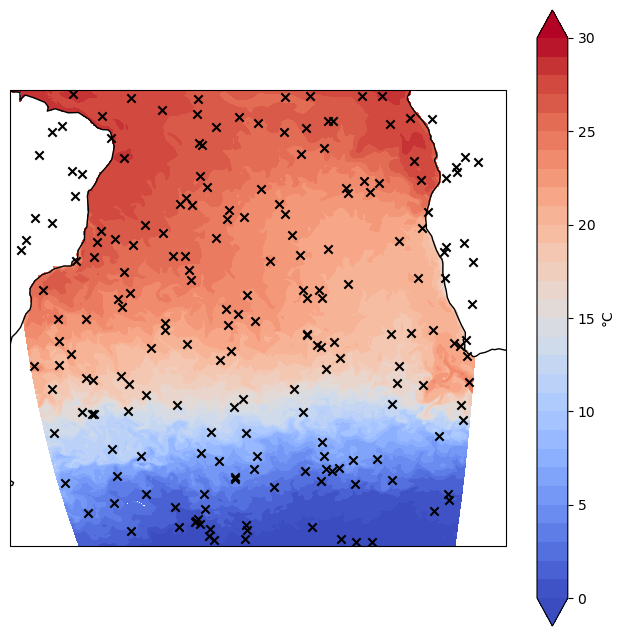

In [11]:
glorys_vars = glorys_ds.isel(time=0, depth=0)

fig, ax = plt.subplots(1,1,figsize=(8,8), subplot_kw={'projection':ccrs.Robinson()})

# Plot background
norm = mplc.Normalize(vmin=0, vmax=30, clip=False)
contourf_ = ax.contourf(glorys_vars.longitude, glorys_vars.latitude, glorys_vars.thetao, levels=[x for x in range(0,31)],\
                        transform=ccrs.PlateCarree(), norm=norm, cmap='coolwarm', extend='both');
cbar = fig.colorbar(contourf_, label="°C", ticks=[x*5 for x in range(0,7)], extend='both')

# Plot points
ax.coastlines()
plot_points(points)

plt.show()

[  4.88384868 -48.35261731]
[-35.70158703 -42.03022454]
[-44.82834491 -29.933611  ]
[-35.06793126 -19.43615302]
[ -6.92230208 -26.08180842]
[-18.45612612 -58.116361  ]
[-48.56722066 -19.58210449]
[ -6.20711314 -27.15041479]
[-19.63663138  -4.76456424]
[-36.09620102 -37.36505702]
[-28.251206   -30.41048373]
[ 18.64576154 -34.79906813]
[ 19.00956499 -27.96935872]
[-34.08855177 -23.7079978 ]
[ -4.33172111 -46.0574572 ]
[ -4.01079249 -27.14961948]
[-16.02399876 -49.73124509]
[-37.92917195 -19.82727339]
[-16.86735138 -29.27930516]
[-40.60832813 -37.82881353]
[-22.16782268  -6.90375189]
[ 16.47181461 -33.0433235 ]
[  4.38371102 -59.86538629]
[ 17.47831718 -53.15520254]
[-1.05866968e-02 -2.53160187e+01]
[-6.28293221 -4.86915625]
[-34.88222572 -38.42374757]
[-2.29016167 -4.01409737]
[-22.01014043 -11.13607212]
[ -7.31514761 -49.98949828]
[19.39042413 -9.31753047]
[-36.41029591  -3.35927293]
[ -4.60868403 -51.30949717]
[  6.71688346 -31.88167302]
[-45.55957941 -35.98074685]
[ -0.01816153 -13.37

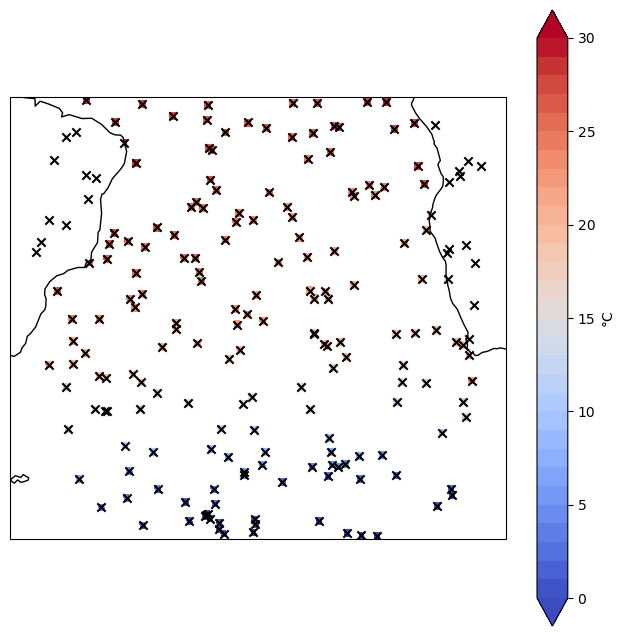

In [12]:
glorys_var = glorys_vars.thetao # We will only have one variable at a time and so we should extract it at the start

fig, ax = plt.subplots(1,1,figsize=(8,8), subplot_kw={'projection':ccrs.Robinson()})

def plot_seascape(seascape):
    ax = plt.gca()
    return ax.contourf(seascape.longitude, seascape.latitude, seascape, levels=[x for x in range(0,31)],\
                        transform=ccrs.PlateCarree(), norm=norm, cmap='coolwarm', extend='both');

# Plot background
for point in points:
    print(point)

    # Get point background
    point_lon, point_lat = point
    seascape = glorys_var.sel(latitude=slice(point_lat-buffer/2, point_lat+buffer/2), longitude=slice(point_lon-buffer/2, point_lon+buffer/2))
    
    if math.prod(list(seascape.shape)) == 0:
        print("Empty seascape. Skipping plot.")
        continue

    contourf_ = plot_seascape(seascape)
    
cbar = fig.colorbar(contourf_, label="°C", ticks=[x*5 for x in range(0,7)], extend='both')

# Plot points
ax.coastlines()
plot_points(points)